In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter

### implementation of basic ae

In [163]:
class Evolutionary_Algorithm:
    __slots__ = [
        "mutation_rate",
        "crossover_rate",
        "number_of_generations",
        "population_size",
        "function_to_optimize",
        "population",
        "problem_dim",
        "hall_of_fame",
    ]

    def __init__(
        self,
        mutation_rate=0.7,
        crossover_rate=0.7,
        number_of_generations=50,
        population_size=100,
    ):
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.function_to_optimize = None
        self.population = None
        self.problem_dim = None
        self.hall_of_fame = []

    def _generate_population(self, n_genes):
        self.population = np.random.uniform(-10, 10, (self.population_size, n_genes))

    def _mutation(self, individual):
        for i in range(len(individual)):
            if np.random.rand() < self.mutation_rate:
                individual += np.random.normal(0, 1, self.problem_dim)
        return individual

    def _crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.problem_dim - 1)
            child1 = np.concatenate(
                (parent1[:crossover_point], parent2[crossover_point:])
            )
            child2 = np.concatenate(
                (parent2[:crossover_point], parent1[crossover_point:])
            )
            return child1, child2
        return parent1, parent2

    def _evaluate_population(self):
        fitness = np.zeros(len(self.population))
        for i, individual in enumerate(self.population):
            fitness[i] = self.function_to_optimize(*individual)
        self.hall_of_fame.append(np.argsort(fitness)[: int(self.population_size * 0.1)])
        return fitness

    def _tournament_selection(self, fitness):
        fitness = 1 / fitness
        probabilities = fitness / np.sum(fitness)
        return self.population[
            np.random.choice(
                range(len(self.population)),
                p=probabilities,
                size=self.population_size - len(self.hall_of_fame[-1]),
                replace=True,
            )
        ]

    def _select_individual(self, n=1):
        return self.population[
            np.random.choice(range(self.population_size), size=n, replace=False)
        ]

    def _visualize_individual(self, individual):
        print(individual)

    def optimize(self, function_to_optimize):
        # initialize the population
        self.function_to_optimize = function_to_optimize
        self.problem_dim = function_to_optimize.__code__.co_argcount
        self._generate_population(self.problem_dim)

        generation_time_to_calculate = [perf_counter()]
        for generation in range(self.number_of_generations):

            # crossover
            children = np.zeros(
                (2 * len(range(0, self.population_size, 2)), self.problem_dim)
            )
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self._select_individual(n=2)
                children[i], children[i + 1] = self._crossover(parent1, parent2)
            self.population = np.vstack([self.population, children])

            # mutation
            mutated = np.zeros((self.population_size, self.problem_dim))
            for i in range(self.population_size):
                individual = self._select_individual()
                mutated[i] = self._mutation(individual)
            self.population = np.vstack([self.population, mutated])

            # evaluate the population and select the best individuals
            fitness = self._evaluate_population()
            print(
                f"iteration {generation} best fitness: {np.min(fitness)} for individual {self.population[self.hall_of_fame[-1][0]]}"
            )
            self.population = np.vstack(
                [
                    self.population[self.hall_of_fame[-1]],
                    self._tournament_selection(fitness),
                ]
            )

### definition of objective functions 

In [131]:
def rastrigin_5d(x, y, z, w, v):

    # this implementation takes 57s to run ae with 100 individuals for 200 generations
    # np.array([x, y, z, w, v])
    # return (
    #     10 * 5
    #     + np.sum(np.array([x, y, z, w, v]) ** 2)
    #     - 10 * np.sum(np.cos(2 * np.pi * np.array([x, y, z, w, v])))
    # )

    # this implementation takes only 30 to run ae with 100 individuals for 200 generations almost twice as fast
    return (
        10 * 5
        + x**2
        + y**2
        + z**2
        + w**2
        + v**2
        - 10
        * (
            np.cos(2 * np.pi * x)
            + np.cos(2 * np.pi * y)
            + np.cos(2 * np.pi * z)
            + np.cos(2 * np.pi * w)
            + np.cos(2 * np.pi * v)
        )
    )


def quadratic_3d(x, y, z):
    return x**2 + y**2 + 2 * z**2

In [164]:
ea = Evolutionary_Algorithm(number_of_generations=200, population_size=20)
ea.optimize(quadratic_3d)

iteration 0 best fitness: 28.445461357797626 for individual [-2.40032347 -4.58181032  0.91948974]
iteration 1 best fitness: 19.874494963173653 for individual [ 2.12095685  3.2374415  -1.56445031]
iteration 2 best fitness: 19.874494963173653 for individual [ 2.12095685  3.2374415  -1.56445031]
iteration 3 best fitness: 10.677067282327561 for individual [ 2.2391091   1.6774239  -1.19367223]
iteration 4 best fitness: 10.677067282327561 for individual [ 2.2391091   1.6774239  -1.19367223]
iteration 5 best fitness: 10.677067282327561 for individual [ 2.2391091   1.6774239  -1.19367223]
iteration 6 best fitness: 5.663747667098271 for individual [-1.16787374  1.42556728 -1.06479494]
iteration 7 best fitness: 4.016456832651429 for individual [-1.28849149  1.27400691  0.60545558]
iteration 8 best fitness: 2.059102318436305 for individual [-0.58721699  0.80965929 -0.72757486]
iteration 9 best fitness: 1.6368900394940296 for individual [-0.19496742 -0.36177726  0.85673653]
iteration 10 best fitne

In [166]:
ea = Evolutionary_Algorithm(number_of_generations=200, population_size=200)
calc_time = ea.optimize(rastrigin_5d)

iteration 0 best fitness: 62.20088615459548 for individual [0.87037951 1.41626557 4.87800999 3.07394247 0.05300019]
iteration 1 best fitness: 45.924966936335636 for individual [ 1.80073032 -0.86924329  4.97717357 -2.10585433 -0.04673598]
iteration 2 best fitness: 45.924966936335636 for individual [ 1.80073032 -0.86924329  4.97717357 -2.10585433 -0.04673598]
iteration 3 best fitness: 37.47920756529813 for individual [ 0.59012166 -0.1177251   0.84679235  3.07394247  0.05300019]
iteration 4 best fitness: 28.374378909410936 for individual [-3.04556927 -0.1177251   0.84679235  3.07394247  0.05300019]
iteration 5 best fitness: 23.33990036531423 for individual [ 1.82232404  0.18006993 -0.93385518  1.87679672 -0.05214282]
iteration 6 best fitness: 10.688230750779567 for individual [ 1.02828947  0.06566372 -0.93385518  1.87679672 -0.05214282]
iteration 7 best fitness: 10.04447829695777 for individual [ 1.02828947  0.06566372 -0.93385518  0.96532575  2.06527018]
iteration 8 best fitness: 10.0444

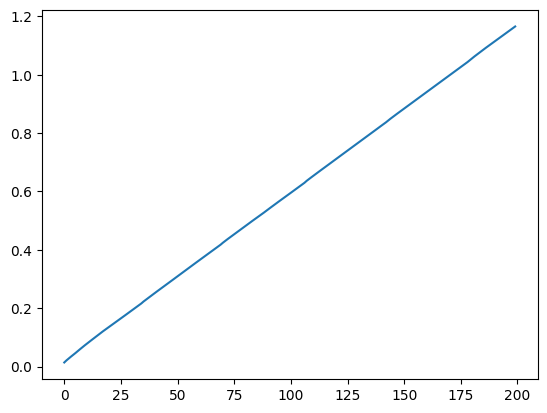

In [162]:
plt.plot(calc_time[1:])